In [3]:
%reset -f

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

# Load each
datasets = {}
for hour in range(24):
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

max_pca = int(datasets[0].columns[-1]) + 1

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-max_pca] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-max_pca] for hour in range(24)}

pca_train = {hour: datasets_train[hour][:, -max_pca:] for hour in range(24)}
pca_test = {hour: datasets_test[hour][:, -max_pca:] for hour in range(24)}

## AR(1)

SMAPE baseline (24 lags) out of sample prediction: 59.79543578834726


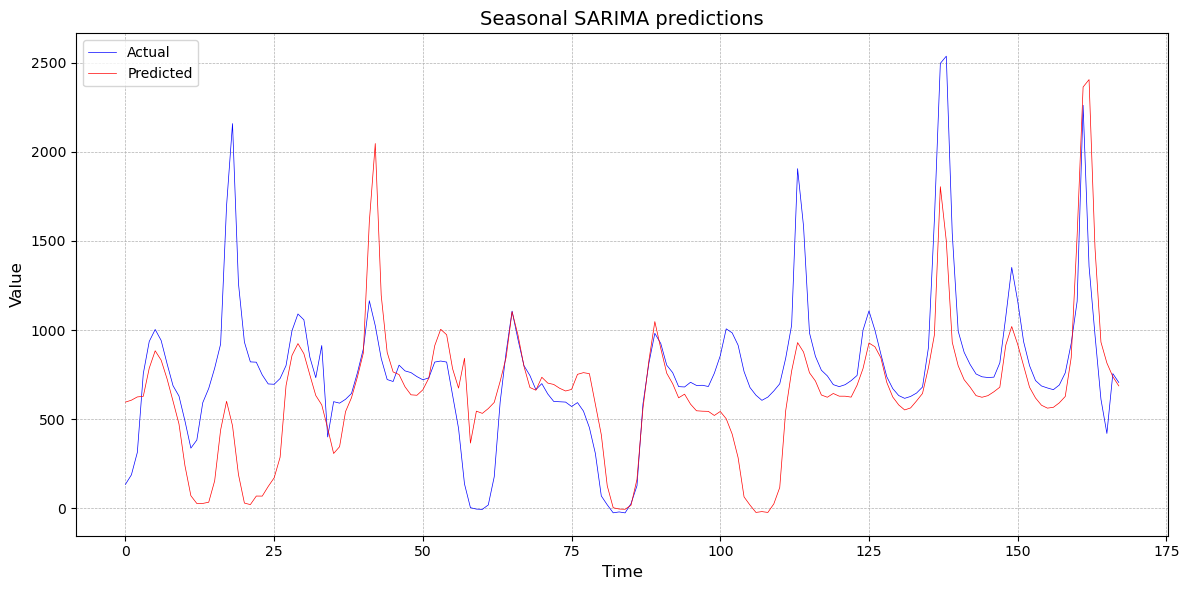

In [2]:
# Fit SARIMAX model
# Replace (p, d, q) and (P, D, Q, s) with appropriate orders based on your data
p, d, q = 1, 0, 0 
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = {}

for hour in range(24):
    model = SARIMAX(
        y_train[hour],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        **{'smoother_output': smoother_output}
    )
    results = model.fit(disp=False)

    # Use the model to predict without refitting
    new_results = results.append(y_test[hour], refit=False)

    # Get predictions for the test period
    predictions = new_results.predict(start=len(y_train[hour]), end=len(y_train[hour]) + len(y_test[hour]) - 1)

    predictions_dict[hour] = predictions

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

smape_baseline = smape(combined_test, combined_predictions)

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(combined_test, combined_predictions, "Seasonal SARIMA predictions")

## SARIMA((1,1,1), (1,1,1, 7))

Hour 0 fitted
Hour 1 fitted


c:\Users\peter\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: 50.88037490188759


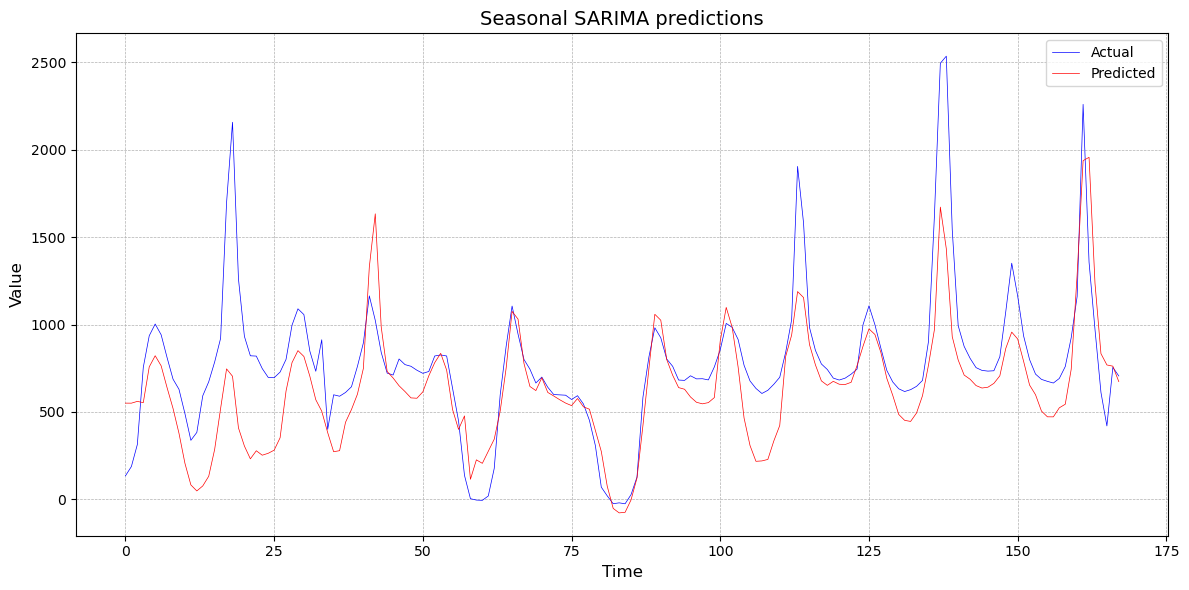

In [3]:
# Fit SARIMAX model
# Replace (p, d, q) and (P, D, Q, s) with appropriate orders based on your data
p, d, q = 1, 1, 1 
P, D, Q, s = 1, 1, 1, 7 

smoother_output = 0

predictions_dict = {}

for hour in range(24):
    model = SARIMAX(
        y_train[hour],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        **{'smoother_output': smoother_output}
    )
    results = model.fit(disp=False, maxiter=10000)

    # Use the model to predict without refitting
    new_results = results.append(y_test[hour], refit=False)

    # Get predictions for the test period
    predictions = new_results.predict(start=len(y_train[hour]), end=len(y_train[hour]) + len(y_test[hour]) - 1)

    predictions_dict[hour] = predictions

    print(f'Hour {hour} fitted')

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

smape_baseline = smape(combined_test, combined_predictions)

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(combined_test, combined_predictions, "Seasonal SARIMA predictions")

## SARIAMAX 

Hour 0 fitted
Hour 1 fitted


c:\Users\peter\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: 50.96999394442793


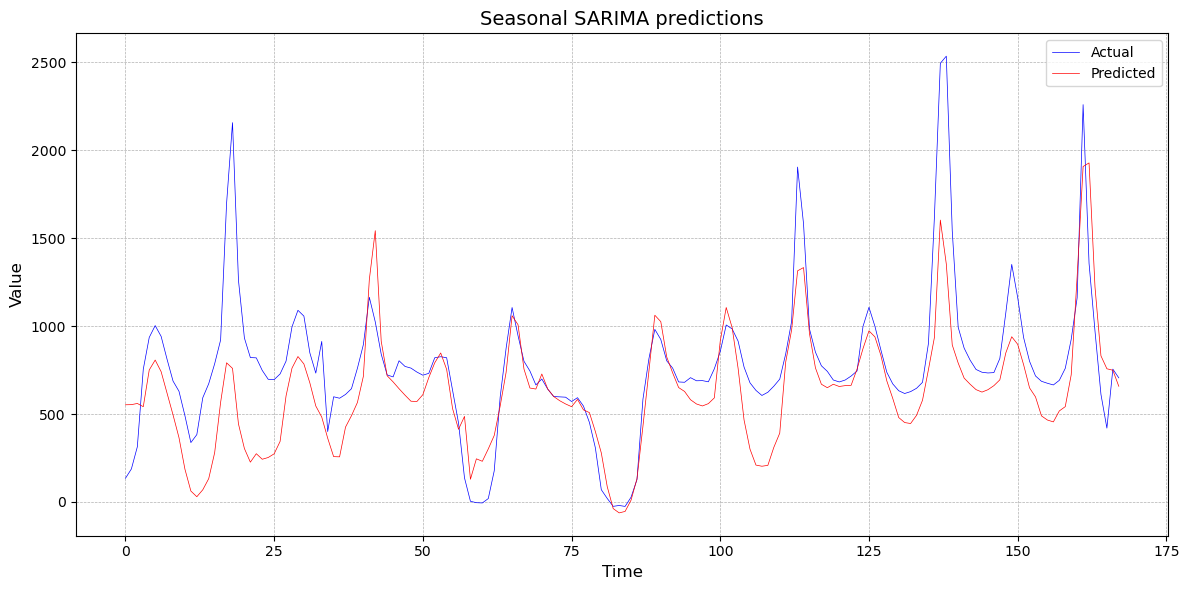

In [10]:
# Fit SARIMAX model
# Replace (p, d, q) and (P, D, Q, s) with appropriate orders based on your data
p, d, q = 1, 1, 1 
P, D, Q, s = 1, 1, 1, 7 

smoother_output = 0

predictions_dict = {}

for hour in range(24):
    model = SARIMAX(
        y_train[hour],
        exog = pca_train[hour],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        **{'smoother_output': smoother_output}
    )
    results = model.fit(disp=False, maxiter=10000)

    # Use the model to predict without refitting
    new_results = results.append(y_test[hour], exog=pca_test[hour], refit=False)

    # Get predictions for the test period
    predictions = new_results.predict(start=len(y_train[hour]), end=len(y_train[hour]) + len(y_test[hour]) - 1, exog=pca_test[hour])

    predictions_dict[hour] = predictions

    print(f'Hour {hour} fitted')

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

smape_baseline = smape(combined_test, combined_predictions)

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(combined_test, combined_predictions, "Seasonal SARIMA predictions")